In [30]:
%load_ext autoreload
%autoreload 2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.signal import periodogram, detrend

from matplotlib.patches import Polygon
from HayesElasticModel_PYTH import *
from Sinus_Analysis_PYTH import funfminsearch, ResidualStandardError, leasqrfunc, FitSinusoid, butterworth_filter
from read_mach_1_file_PYTH import read_mach_1_file, read_mach_1_files, select_mach_1_file
#from Stress_Relaxation_Fit_PYTH import *
from Analysis_Map_file_PYTH import select_files_dir, get_subSurfaces, interpolateMAP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
mach_1_data = read_mach_1_file(select_mach_1_file())

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [31]:
function = 'Sinusoid-1'
units_gf = "Single" in mach_1_data[function]["<INFO>"]["Load Cell Type:"]
Time = mach_1_data[function]["<DATA>"]["Time"]
posZ = mach_1_data[function]["<DATA>"]["Position (z)"]
Fz = mach_1_data[function]["<DATA>"]["Fz"]
if units_gf:
    Fz = Fz*0.00980665
Fz_filtered = butterworth_filter(Fz)
frequency = float(mach_1_data[function]["<Sinusoid>"]["Frequency, Hz:"])
Params_data_1_2, data_1_sin, data_2_sin, t_extra, data_1_extra, data_2_extra, ser_data_1, ser_data_2 = FitSinusoid(Time,  frequency, posZ, Fz, method = "trf", lossType = "soft_l1", fscale = 0.001, trim_data = True)


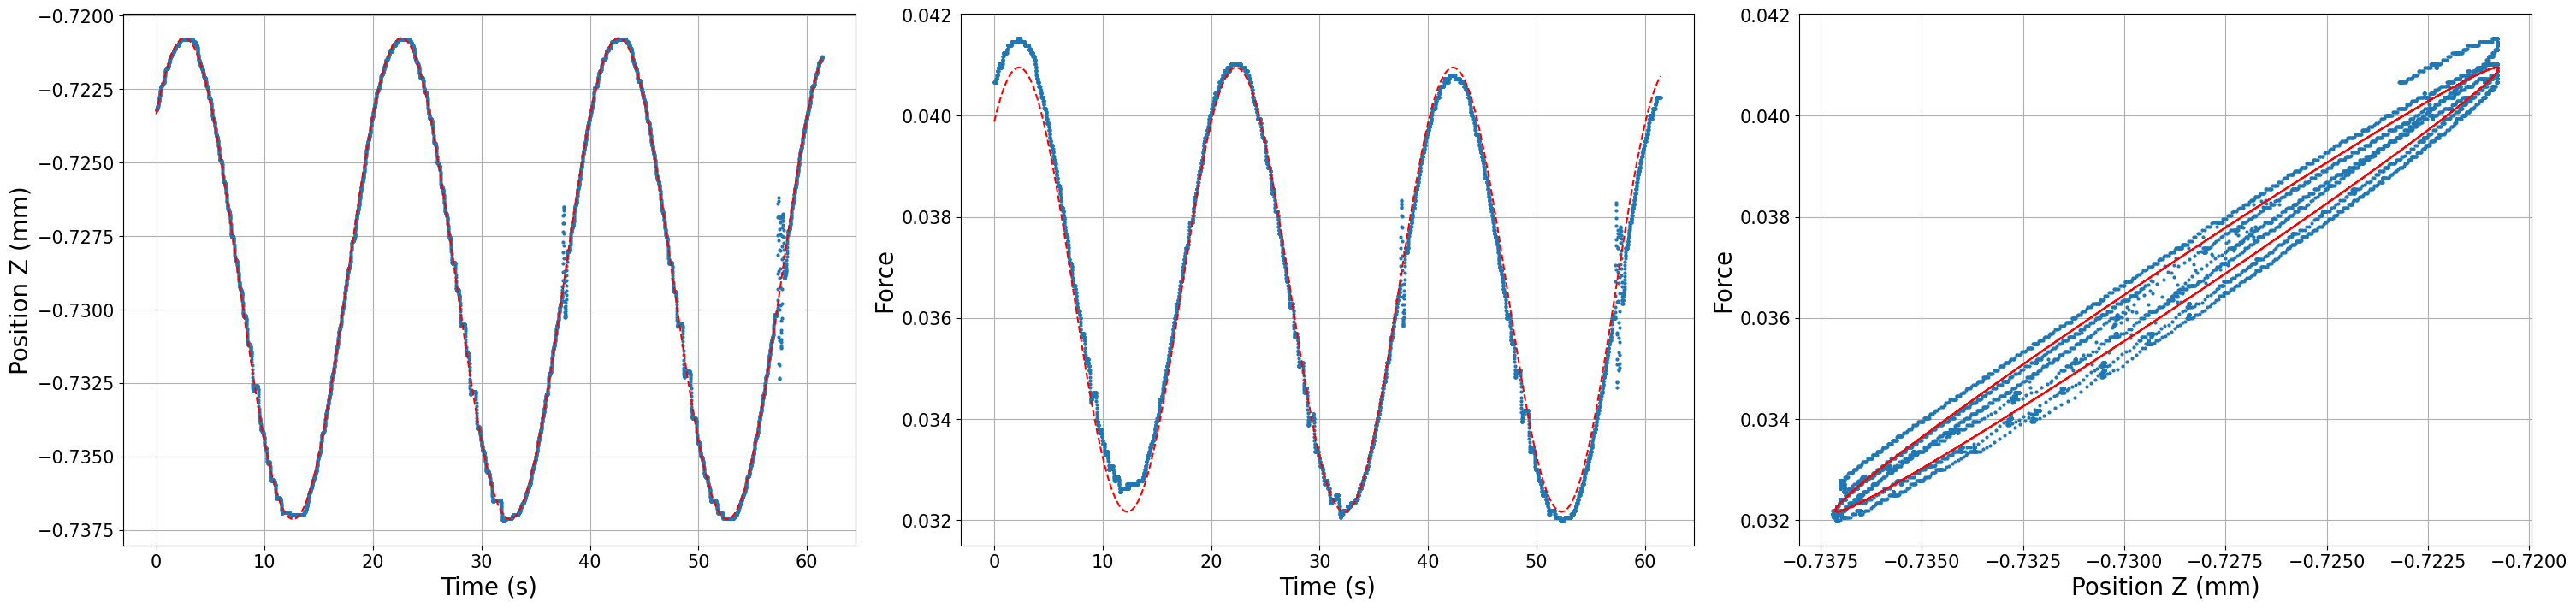

In [29]:
fig, axes = plt.subplots(1,3, constrained_layout = True, figsize = (30, 7))
axes[0].plot(t_extra, data_1_extra, "o", markersize = 2)
axes[0].plot(t_extra, data_1_sin, "--r")
axes[0].set_ylabel("Position Z (mm)",size=20)
axes[0].set_xlabel("Time (s)",size=20)
axes[0].tick_params(axis = 'both', which = 'major', labelsize=15)
axes[0].grid()

axes[1].plot(t_extra, data_2_extra, "o", markersize = 2)
axes[1].plot(t_extra, data_2_sin, "--r")
axes[1].set_ylabel("Force (N)",size=20)
axes[1].set_xlabel("Time (s)",size=20)
axes[1].tick_params(axis = 'both', which = 'major', labelsize=15)
axes[1].grid()

axes[2].plot(data_1_extra, data_2_extra, "o", markersize = 2)
axes[2].plot(data_1_sin, data_2_sin, "--r")
axes[2].set_ylabel("Force (N)",size=20)
axes[2].set_xlabel("Position Z (mm)",size=20)
axes[2].tick_params(axis = 'both', which = 'major', labelsize=15)
axes[2].grid()
plt.show()